In [214]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle 
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

### загружаем обработанную таблицу и разбиваем на обучающий и валидационный набор

In [174]:
df = pd.read_csv('processd_df.csv', sep = ';') #загрузка таблицы
y = df['CO(GT)'] #берём таргет
x = df.loc[:, ['Month', 'Weekday', 'Hour', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']] #оставляем столбцы без таргета
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42) #разбиваем на обучающую и валидационные выборки

### Нормализуем данные при помощи класса StandardScaler пакета sklearn. 

In [175]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) #находим параметры нормализации и на месте нормализуем обучающий набор
X_test = scaler.transform(X_test) # также валидационынй набор

In [202]:
with open('models\scaler.pkl', 'wb') as file: #сохраняем StandartScaler для использования его параметрах на данных для предсказания
    pickle.dump(scaler, file)

### Далее поочерёдно обучаем Линейную модель, Лассо, Случайный лес, Support Vector Regressor (SVR), К-ближайших соседей и полносвязанную нейронную сеть

In [182]:
lin_model = LinearRegression() #загружаем модель
lin_model.fit(X_train, y_train) #обучаем на данных
y_pred = lin_model.predict(X_test) #делаем предсказания
print('Метрика R2:', r2_score(y_test, y_pred)) #смотрим метрику r2
print('MAE:', mean_absolute_error(y_test, y_pred)) # смотрим размер ошибки MAE

Метрика R2: 0.9184234442438407
MAE: 0.24967928601306663


In [179]:
with open('models\linear_model.pkl', 'wb') as file: #сохраняем линейную модель
    pickle.dump(lin_model, file)

### Обучаем Lasso и подбираем лучшие гиперапараметры методом "поиска по сетке" с кросс-валидацией на k-folds = 5

In [10]:
lasso_model = Lasso() #загружаем модель
parameters = {'alpha': [0.1, 0.5, 1, 3, 5]} #гиперпараметы (всего 5 вариантов модели с  разными гиперпараметрами будет построено)
lasso = GridSearchCV(lasso_model, parameters)
lasso.fit(X_train, y_train) #обучаем на данных
y_pred = lasso.predict(X_test) #делаем предсказания
print('Лучшие гиперпараметры', lasso.best_params_)  #смотрим лучший вариант гиперпараметров
print('Метрика R2:', r2_score(y_test, y_pred)) #смотрим метрику r2
print('MAE:', mean_absolute_error(y_test, y_pred)) # смотрим размер ошибки MAE

Лучшие гиперпараметры {'alpha': 0.1}
Метрика R2: 0.9096827831592366
MAE: 0.26393723019037146


In [183]:
with open('models\lasso_model.pkl', 'wb') as file: #сохраняем модель
    pickle.dump(lasso, file)

### Обучаем Support Vector Regressor и подбираем лучшие гиперапараметры методом "поиска по сетке" с кросс-валидацией на k-folds = 5

In [184]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 5, 10, 12]}  #гиперпараметы (всего 8 вариантов модели с  разными гиперпараметрами будет построено)
svr_model = SVR() #загружаем модель
svr = GridSearchCV(svr_model, parameters)
svr.fit(X_train, y_train) #обучаем на данных
print('Лучшие гиперпараметры', svr.best_params_) #смотрим лучший вариант гиперпараметров
y_pred = svr.predict(X_test)#делаем предсказания
print('Метрика R2:', r2_score(y_test, y_pred)) #смотрим метрику r2
print('MAE:', mean_absolute_error(y_test, y_pred)) # смотрим размер ошибки MAE

Лучшие гиперпараметры {'C': 12, 'kernel': 'rbf'}
Метрика R2: 0.9582851577546982
MAE: 0.16804714849495195


In [185]:
with open('models\svr_model.pkl', 'wb') as file: #сохраняем модель
    pickle.dump(svr, file)

### Обучаем Случайный лес и подбираем лучшие гиперапараметры методом "поиска по сетке" с кросс-валидацией на k-folds = 3

In [186]:
forest_model = RandomForestRegressor(warm_start = True) #загружаем модель
parameters = {'n_estimators':(100, 150, 200), 
                'criterion':['squared_error', 'absolute_error'],
                'max_depth': [15, 20],
                'max_features': ['sqrt', 'log2']}  #гиперпараметы (всего 24 вариантов модели с  разными гиперпараметрами будет построено)


forest = GridSearchCV(forest_model, parameters, cv = 3)
forest.fit(X_train, y_train) #обучаем на данных
print('Лучшие гиперпараметры', forest.best_params_) #смотрим лучший вариант гиперпараметров
y_pred = forest.predict(X_test) #делаем предсказания
print('Метрика R2:', r2_score(y_test, y_pred)) #смотрим метрику r2
print('MAE:', mean_absolute_error(y_test, y_pred)) # смотрим размер ошибки MAE

Лучшие гиперпараметры {'criterion': 'squared_error', 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 200}
Метрика R2: 0.937878178448896
MAE: 0.20816606826314796


In [187]:
with open(r'models\forest_model.pkl', 'wb') as file: #сохраняем модель
    pickle.dump(forest, file)

### Обучаем К ближайших соседей и подбираем лучшие гиперапараметры методом "поиска по сетке" с кросс-валидацией на k-folds = 5

In [188]:
#K-ближайших соседей
neigh_model = KNeighborsRegressor()
parameters = {'n_neighbors': (3, 5, 7, 9, 11), 
                'weights': ['uniform', 'distance'],
                'algorithm': ['auto', 'ball_tree', 'kd_tree']} #гиперпараметы (всего 30 вариантов модели с  разными гиперпараметрами будет построено)


neigh = GridSearchCV(neigh_model, parameters)
neigh.fit(X_train, y_train) #обучаем на данных
print('Лучшие гиперпараметры', neigh.best_params_) #смотрим лучший вариант гиперпараметров
y_pred = neigh.predict(X_test)  #делаем предсказания
print('Метрика R2:', r2_score(y_test, y_pred)) #смотрим метрику r2
print('MAE:', mean_absolute_error(y_test, y_pred)) # смотрим размер ошибки MAE

Лучшие гиперпараметры {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'}
Метрика R2: 0.9449495321123889
MAE: 0.2190635558916494


In [189]:
with open(r'models\knn_model.pkl', 'wb') as file: #сохраняем модель
    pickle.dump(neigh, file)

### Далее создаём полносвязанную нейронную сеть, состоящую из 4 линейных слоёв, функции активации ReLu, нормализации и Dropout с вероятность 0.2. Для этого используем пакет pytroch

In [221]:
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch

In [143]:
#создаём класс для загрузки данных
class air_dataset(Dataset): #наследуем от родительского класса Dataset
    def __init__(self, x_train, y_train):
        self.x = x_train
        self.y = y_train
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, ind):
        features = torch.from_numpy(self.x.iloc[ind].to_numpy()).to(torch.float32)  #переводим столбец таблицы в формата тензора с числами float 32
        label = torch.tensor(self.y.iloc[ind]).to(torch.float32) #переводим столбец таблицы в формата тензора с числами float 32
        return features, label  #возвращаем тензор с признаками и тензор с таргетами
    

In [144]:
train_dataset = air_dataset(X_train, y_train) #инициализируем класс загрузки данных для обучающего набора
test_dataset = air_dataset(X_test, y_test) #инициализируем класс загрузки данных для валидационного набора

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True) #создаём dataloader для обучающего набора
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = False) #создаём dataloader для валидационного набора

### Создаём класс полносвязанной нейронной сети

In [219]:
class DenseNet(nn.Module):
    def __init__(self):
        super().__init__()
        #простая последовательность слоёв
        self.layers = nn.Sequential(nn.Linear(in_features=14, out_features = 14), #линейный слой
                                    nn.ReLU(), #нелинейная функция активации
                                    nn.BatchNorm1d(14), #нормализации данных
                                    nn.Dropout(0.2), #отключение нейроной в вероятностью 0.2

                                    nn.Linear(in_features=14, out_features = 8), #линейный слой
                                    nn.ReLU(), #нелинейная функция активации
                                    nn.BatchNorm1d(8), #нормализации данных
                                    nn.Dropout(0.2), #отключение нейроной в вероятностью 0.2

                                    nn.Linear(in_features=8, out_features = 4), #линейный слой
                                    nn.ReLU(), #нелинейная функция активации
                                    nn.BatchNorm1d(4), #нормализации данных
                                    nn.Dropout(0.2), #отключение нейроной в вероятностью 0.2

                                    nn.Linear(in_features=4, out_features = 1), #линейный слой
                                    nn.ReLU() #нелинейная функция активации
        )
    
    def forward(self, input): #функция прямого прохода нейроннйо сети
        return self.layers(input)

In [169]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' #если видеокарта доступна, то обучаем на ней
model = DenseNet().to(device) #инициализируем модель и переносим на доступное устрйоство
epochs = 7 #количество эпох
lr = 0.01 #шаг обучения
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # оптимизаторв Adam
loss_fn = nn.MSELoss() #функция потерь MSE
print(f'Обучение будет проходить на {device}')

Обучение будет проходить на cuda


In [170]:
for epoch in range(epochs): # начинаем обучение в цикле
    
    #инициализруем метрики, которые будем считать по эпохам
    train_loss = 0
    r2_train = 0
    r2_test = 0
    test_loss = 0

    model.train() #переводим модель в режим обучения
    for batch, y in train_loader: #берём батч и таргет
        batch, y = batch.to(device), y.to(device)  #переносим на доступное устрйоство
        y_pred = model(batch).squeeze() #делаем предсказание
        loss = loss_fn(y, y_pred) #счиатем потери
        train_loss += loss.item()/len(train_loader) #сохраняем потери на текущей итерации
        r2_train += r2_score(y.cpu().detach().numpy(), y_pred.cpu().detach().numpy())/len(train_loader) #счиатем метрику на текущей итерации
        loss.backward() #обратное распространение ошибки
        optimizer.step() #обновляем веса модели
        optimizer.zero_grad() #обнулдяем градиент

    model.eval() #переводим модель в режим предсказания
    with torch.no_grad(): #отключаем подсчёт градиента 
        for batch, y in test_loader: #берём батч и таргет
            batch, y = batch.to(device), y.to(device) #переносим на доступное устрйоство
            y_pred = model(batch).squeeze() #делаем предсказание
            loss = loss_fn(y, y_pred) #счиатем потери
            test_loss += loss.item()/len(test_loader) #сохраняем потери на текущей итерации
            r2_test += r2_score(y.cpu().detach().numpy(), y_pred.cpu().detach().numpy())/len(test_loader) #счиатем метрику на текущей итерации
    
    print(f'Эпоха обучения {epoch + 1}')
    print(f'Потеря на обучении: {train_loss}', f'R2 на обучении: {r2_train}')
    print(f'Потеря на валидации: {test_loss}', f'R2 на обучении: {r2_test}')

Эпоха обучения 1
Потеря на обучении: 2.1760485537198124 R2 на обучении: -0.07467322623541899
Потеря на валидации: 0.7573408683141072 R2 на обучении: 0.5704605981514395
Эпоха обучения 2
Потеря на обучении: 1.0122829876383959 R2 на обучении: 0.5014445016705348
Потеря на валидации: 0.33492919305960334 R2 на обучении: 0.811746288836963
Эпоха обучения 3
Потеря на обучении: 0.8697942200363896 R2 на обучении: 0.5617249961982644
Потеря на валидации: 0.3441036691268285 R2 на обучении: 0.8062547471351885
Эпоха обучения 4
Потеря на обучении: 0.8024789365578671 R2 на обучении: 0.6072190274399084
Потеря на валидации: 0.24369235336780548 R2 на обучении: 0.8632209963943733
Эпоха обучения 5
Потеря на обучении: 0.7667702667567199 R2 на обучении: 0.6301493862323072
Потеря на валидации: 0.273362934589386 R2 на обучении: 0.8462885733558604
Эпоха обучения 6
Потеря на обучении: 0.6616499566910219 R2 на обучении: 0.6724298607624405
Потеря на валидации: 0.2792430991927783 R2 на обучении: 0.8430280807102641
Эп

In [ ]:
torch.save(model, r'models\nn.pt') #сохраняем обученную модель

### Итоговые потери и метрика R2 по всем построенным моделям с лучшей комбинацией гиперпараметров

In [196]:
metrics_df = pd.DataFrame(data = [[0.918, 0.249, 'Линейная модель'],
                                 [0.909, 0.263, 'Лассо'],       
                                 [0.958, 0.168, 'SVR'],
                                 [0.937, 0.208, 'Случайный лес'],
                                 [0.944, 0.219, 'KNN'],
                                 [0.878, 0.214, 'Полносвязанная \n нейронная сеть']], columns = ['R2', 'MAE', 'Модель'])
metrics_df                                 

,R2,MAE,Модель
0,0.918,0.249,Линейная модель
1,0.909,0.263,Лассо
2,0.958,0.168,SVR
3,0.937,0.208,Случайный лес
4,0.944,0.219,KNN
5,0.878,0.214,Полносвязанная \n нейронная сеть


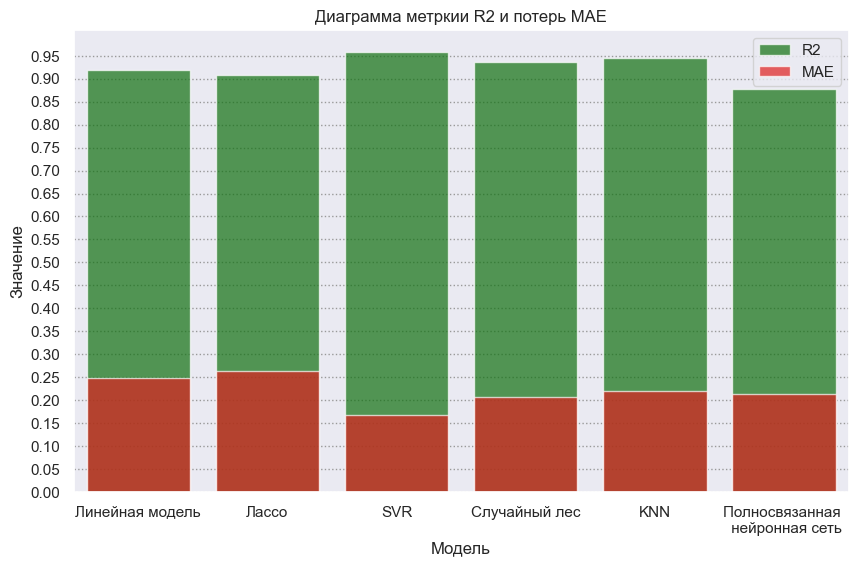

In [230]:
plt.figure(figsize=(10, 6))
 
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
ax = sns.barplot(x='Модель', y='R2', data=metrics_df, color='green', alpha=0.7, label='R2')
sns.barplot(x='Модель', y='MAE', data=metrics_df, color='red', alpha=0.7, label='MAE', ax = ax)
plt.yticks(np.arange(0, 1, 0.05))  
plt.xlabel('Модель')
plt.ylabel('Значение')
plt.title('Диаграмма метркии R2 и потерь MAE')
plt.legend() 
plt.show() 
fig = ax.get_figure()
fig.savefig('Диаграмма метркии R2 и потерь MAE')
